# Predicting Diabetes Diagnosis Using Health Factors
Data Science 3870 <br> Dr. Jacob Martin<br>Authors: Abby Howard, Arai Lubas, Ella Stasko



## Introduction
We are interested in exploring what combination of the collected features best predicts whether an individual has diabetes. Given these inputs, we want to determine whether we can create a model to predict this accurately.

Our team will use the Healthcare Diabetes Dataset from Kaggle. Each instance represents various aspects of an individual’s health data and their diagnosis or non-diagnosis of diabetes. It was last updated in 2023, meaning the data is recent and relevant. The dataset is originally from the National Institute of Diabetes and Digestive and Kidney Diseases (NIDDK). There are 2,768 patients included in the data, with 10 features recorded. Each instance represents a unique individual with recorded features listed below:

1.	**Id**: Unique identifier for each data entry.
2. **Pregnancies**: Number of times pregnant. (Includes people who cannot get pregnant).
4.	**Glucose**: Plasma glucose concentration over 2 hours in an oral glucose tolerance test.
5.	**BloodPressure**: Diastolic blood pressure (mm Hg).
6.	**SkinThickness**: Triceps skinfold thickness (mm). Indicator of body fat distribution.
7.	**Insulin**: 2-Hour serum insulin (mu U/ml).
8.	**BMI**: Body mass index (weight in kg / height in m^2).
9.	**DiabetesPedigreeFunction**: Diabetes pedigree function, a genetic score of diabetes.
10.	**Age**: Age in years.
11.	**Outcome**: Binary classification indicating the presence (1) or absence (0) of diabetes.
   
Features we are particularly interested in to predict whether the individual has diabetes are glucose, diabetes pedigree function, and insulin features. 

## Exploratory Data Analysis
Before creating our model to predict diabetes diagnosis, we will evaluate the dataset through visualization. It is important to explore data features to identify any abnormalities in the data. First we need to read in our data and confirm there are no missing values.


In [3]:
# Import modules
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import warnings 
from scipy.stats import ttest_ind
from sklearn import tree, ensemble
import sklearn.linear_model as lm
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix
warnings.filterwarnings('ignore')

In [4]:
# Read in the dataset and set the patient ID as the index
data = pd.read_csv('Healthcare-Diabetes.csv', index_col= 'Id')
data

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
Id,,,,,,,,,
1,6,148,72,35,0,33.6,0.627,50,1
2,1,85,66,29,0,26.6,0.351,31,0
3,8,183,64,0,0,23.3,0.672,32,1
4,1,89,66,23,94,28.1,0.167,21,0
5,0,137,40,35,168,43.1,2.288,33,1
...,...,...,...,...,...,...,...,...,...
2764,2,75,64,24,55,29.7,0.370,33,0
2765,8,179,72,42,130,32.7,0.719,36,1
2766,6,85,78,0,0,31.2,0.382,42,0


In [5]:
# Check for missing values 
data.isna().any()

Pregnancies                 False
Glucose                     False
BloodPressure               False
SkinThickness               False
Insulin                     False
BMI                         False
DiabetesPedigreeFunction    False
Age                         False
Outcome                     False
dtype: bool

In [6]:
# Check for zero values
(data.iloc[: ,1:8] == 0).sum()

Glucose                       18
BloodPressure                125
SkinThickness                800
Insulin                     1330
BMI                           39
DiabetesPedigreeFunction       0
Age                            0
dtype: int64

The data does not contain any missing values however, we noticed that there are multiple observations with zero values recorded for features that cannot equal zero (age, BMI, Insulin etc.)

We will assume that for features: Glucose, Blood Pressure, Skin Thickness, Insulin, BMI, Diabetes Pedigree Function, and Age, values of zero are improbable and thus are missing values that need to be removed. We include further analysis to determine how to approach this problem. Features such as Insulin and Skin Thickness have a large number of zeros and in order to determine whether these features should be removed from the dataset to preserve sample size or kept at the expense of a smaller sample size, we will perfom individual analyses.

First we create DataFrames of each variable against outcome removing all zero values. We then plot the Age, BMI, and Pregnancies distributions of the data to start gain an understanding of our patient demographics. 

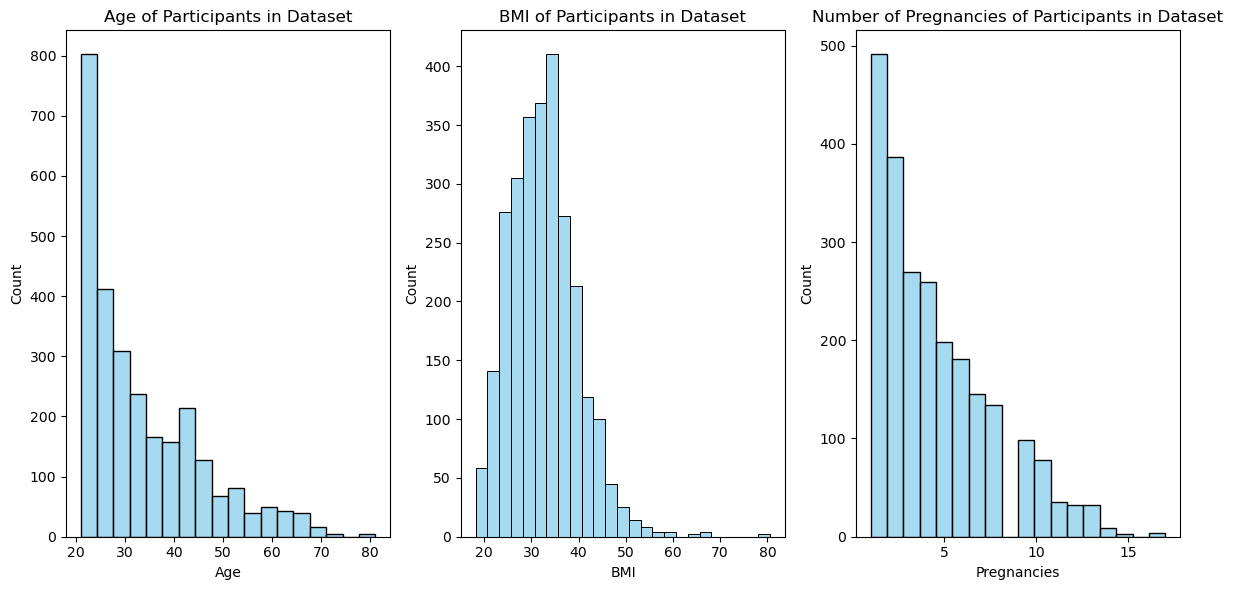

In [8]:
# Create DataFrames for each variable against outcome removing zero values to assess trends via violin plots
dataframes = {} 

# Generating individual dataframes for each variable containing the variable and outcome
for col in data:
    if col == 'Pregnancies':
        dataframes[col] = data.loc[:, (col, 'Outcome')]
    if col == 'Outcome':
        pass
    # Remove zero value rows for all variables except pregancies and outcome
    else:
        dataframes[col] = data.loc[:, (col, 'Outcome')].query('`{}` != 0'.format(col))

# Create a variable to hold the desired palette colors for graphs
colors = ['skyblue','palevioletred']

# Plot the Age Distribution of participants in a subplot
plt.figure(1, figsize = (12,6), clear = True)
plt.tight_layout()
plt.subplot(1,3,1)
sns.histplot(dataframes['Age'], 
             x = 'Age',
             bins = 18,
             color = 'skyblue')
plt.title('Age of Participants in Dataset')

# Plot the BMI distribution of Participants in a sub plot
plt.subplot(1,3,2)
sns.histplot(dataframes['BMI'], 
             x = 'BMI',
             bins = 25,
             color = 'skyblue')
plt.title('BMI of Participants in Dataset')

# Plot the Distribution of the number of pregnancies in a subplot
plt.subplot(1,3,3)
sns.histplot(dataframes['Pregnancies'], 
              x = 'Pregnancies',
              bins = 18,
              color = 'skyblue')
plt.title('Number of Pregnancies of Participants in Dataset')

plt.tight_layout();

From this we see the overall age of the patients is rightly skewed  ranging from 20-80 years old. The overall BMI of the population is somewhat normally distributed with a slight right skew and the number of pregnancies in the data is rightly skewed ranging from 0 to around 17.

We next isolated each feature and grouped the values by outcome. This allows us to visualize and potentially identify any obvious intra-variable distribution difference against the outcome, diabetes. 

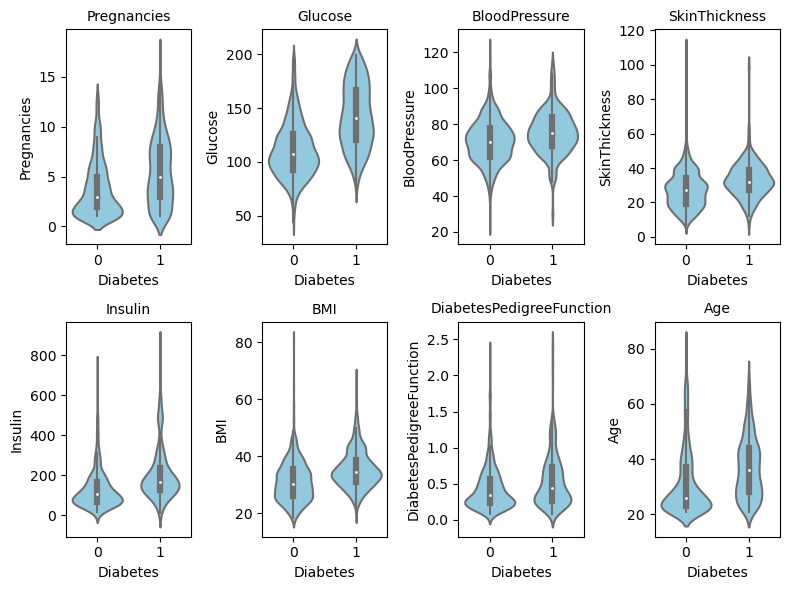

In [10]:
# Create figure
plt.figure(1, figsize = (8,6), clear = True)
subplot_num = 1

# Loop through features and plot separated by outcome
for key in dataframes:
    plt.subplot(2, 4, subplot_num)
    plt.title(f"{key}", size = 10)
    sns.violinplot(data = dataframes[key], 
                   y = key, 
                   x = 'Outcome', 
                   alpha = 0.8,
                   palette =  ['skyblue', 'skyblue']
                  )
    plt.xlabel('Diabetes')
    plt.xticks([0,1])
    subplot_num +=1 

plt.tight_layout()

**Pregnancies**: It appears that patients with diabetes have a wider distribution of number of pregnancies and a higher median. This becomes hard to interpret as the data (including the documentation) does not specify sex and thus may include patients unable to have children. This might jepordize the valididity of using this feature. Alternatively, as sex is not a feature of this dataset it may not impact diabetes outcome. 

**Glucose**: Patients with diabetes have on average a higher blood glucose level than those without, this is a possible feature for prediction as the distributions appear distinct from one another.

**Blood Pressure**: Patients with diabetes have a slighly higher median diastolic blood pressure than those without, but overall the distributions appear similar.

**Skin Thickeness**: Patients with diabetes have a slighly higher median skin thickness than those without, but overall the distributions appear similar. This is a feature with a high missing rate (800 values) and the minimal difference in distribution and median begins to suggest removal of this feature would be acceptable. 

**Insulin**: Patients with diabetes have a higher median 2-hour serum insulin than those without. This feature has a high missing rate (1330 values) and the significant difference in median insulin value suggests it might impact the effectiveness of prediction. This further solidifies that more evaluation of the insulin feature is needed before its removal. 

**BMI**: Patients with diabetes have a higher median BMI follow a narrow, normal distribution, while patients without diabetes follow a wider distribution.

**Diabetes Pedigree Function**: Patients with and without diabetes follow a similar right skewed distribution of diabetes pedigree function with comparable median values.

**Age**: Patients with diabetes are, on average, older than those without and patients with diabetes have a much wider distribution.



### Summary Statistics

To further examine the relationships between the variables and diabetes diagnoses, we performed two-sample independent t-tests to evaluate the differences in means between the groups and whether or not they are statistically significant. 

In [12]:
# Store the numerical feature names to test
features = ['Pregnancies','Glucose','BloodPressure','SkinThickness','Insulin', 'BMI', 'DiabetesPedigreeFunction','Age']

# Store t-test results
t_test_results = []

# Loop through each feature to perform the t-tests
for feature in features:
    group_negative = dataframes[feature][dataframes[feature]['Outcome'] == 0][feature]
    group_positive = dataframes[feature][dataframes[feature]['Outcome'] == 1][feature]
    mean_diff = np.abs(group_negative.mean()-group_positive.mean())

    # Perform t-test
    t_stat, p_val = ttest_ind(group_negative, group_positive, axis = 0, equal_var = False)

    # Store results
    t_test_results.append({
        'Feature': feature,
        'Absolute Mean Difference': mean_diff,
        'T-Statistics': round(t_stat, 3),
        'P-value': p_val,
        'Significant': p_val < 0.05
    })
t_test_df = pd.DataFrame(t_test_results)
t_test_df

,Feature,Absolute Mean Difference,T-Statistics,P-value,Significant
0,Pregnancies,1.804954,-12.825,1.095364e-35,True
1,Glucose,31.649077,-28.175,2.541167e-143,True
2,BloodPressure,4.577578,-9.215,8.382725e-20,True
3,SkinThickness,5.688812,-11.485,3.765410e-29,True
4,Insulin,71.373846,-10.886,8.967390e-26,True
5,BMI,4.379776,-16.035,1.749866e-54,True
6,DiabetesPedigreeFunction,0.110130,-8.015,2.088811e-15,True
7,Age,5.876161,-13.109,9.236400e-38,True


All features have a significant p-value. While only the means of Glucose and Insulin are drastically different, because the sample sizes are all large it creates large test statistics and small p-values. P-Values are often ignored in clinical work because it is more clinically relevant to look at the magnitude of the difference of the relevant metric. With a large enough sample size even small changes that are not clinically relevant could be statistially significant. As seen above, the mean difference of Blood Pressure between patients with and without diabetes is ~4.6; while this is statistically significant, a difference in Blood Pressure of 4.6mmHg is not clinically relevant. However we cannot anticipate which features will be the useful in predicting diabetes using this information. Yet, Glucose and Insulin have a more relevant magnitude of difference in their mean values across outcomes indicating a higher chance of them being a useful predictor and the t-test analysis does not suggest the removal of any features. 

### Insulin Sub-Analysis

While Insulin has a large percent of its values missing, because of its high predictive potential, we will perform sub-analyses with and without insulin as a feature.


In [14]:
# Remove observations with missing values of Glucose, Blood Pressure, BME, and Insulin
cleaned_data_insulin = data.query('Glucose !=0 & BloodPressure !=0 & BMI !=0 & Insulin !=0').copy()

# Remove feature from dataset with substantial missing value: Skin Thickness
cleaned_data_insulin.drop(['SkinThickness'], axis = 1, inplace = True)
cleaned_data_insulin

,Pregnancies,Glucose,BloodPressure,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
Id,,,,,,,,
4,1,89,66,94,28.1,0.167,21,0
5,0,137,40,168,43.1,2.288,33,1
7,3,78,50,88,31.0,0.248,26,1
9,2,197,70,543,30.5,0.158,53,1
14,1,189,60,846,30.1,0.398,59,1
...,...,...,...,...,...,...,...,...
2763,1,79,60,48,43.5,0.678,23,0
2764,2,75,64,55,29.7,0.370,33,0
2765,8,179,72,130,32.7,0.719,36,1


Clearly, maintaining insulin as a feature reduces the sample size of the dataset by almost 50% which is a significant reduction.

We will next show the pairwise correlation between all features of the cleaned data set with insulin to see if there is any clear relationship between outcome and any two features of the dataset.

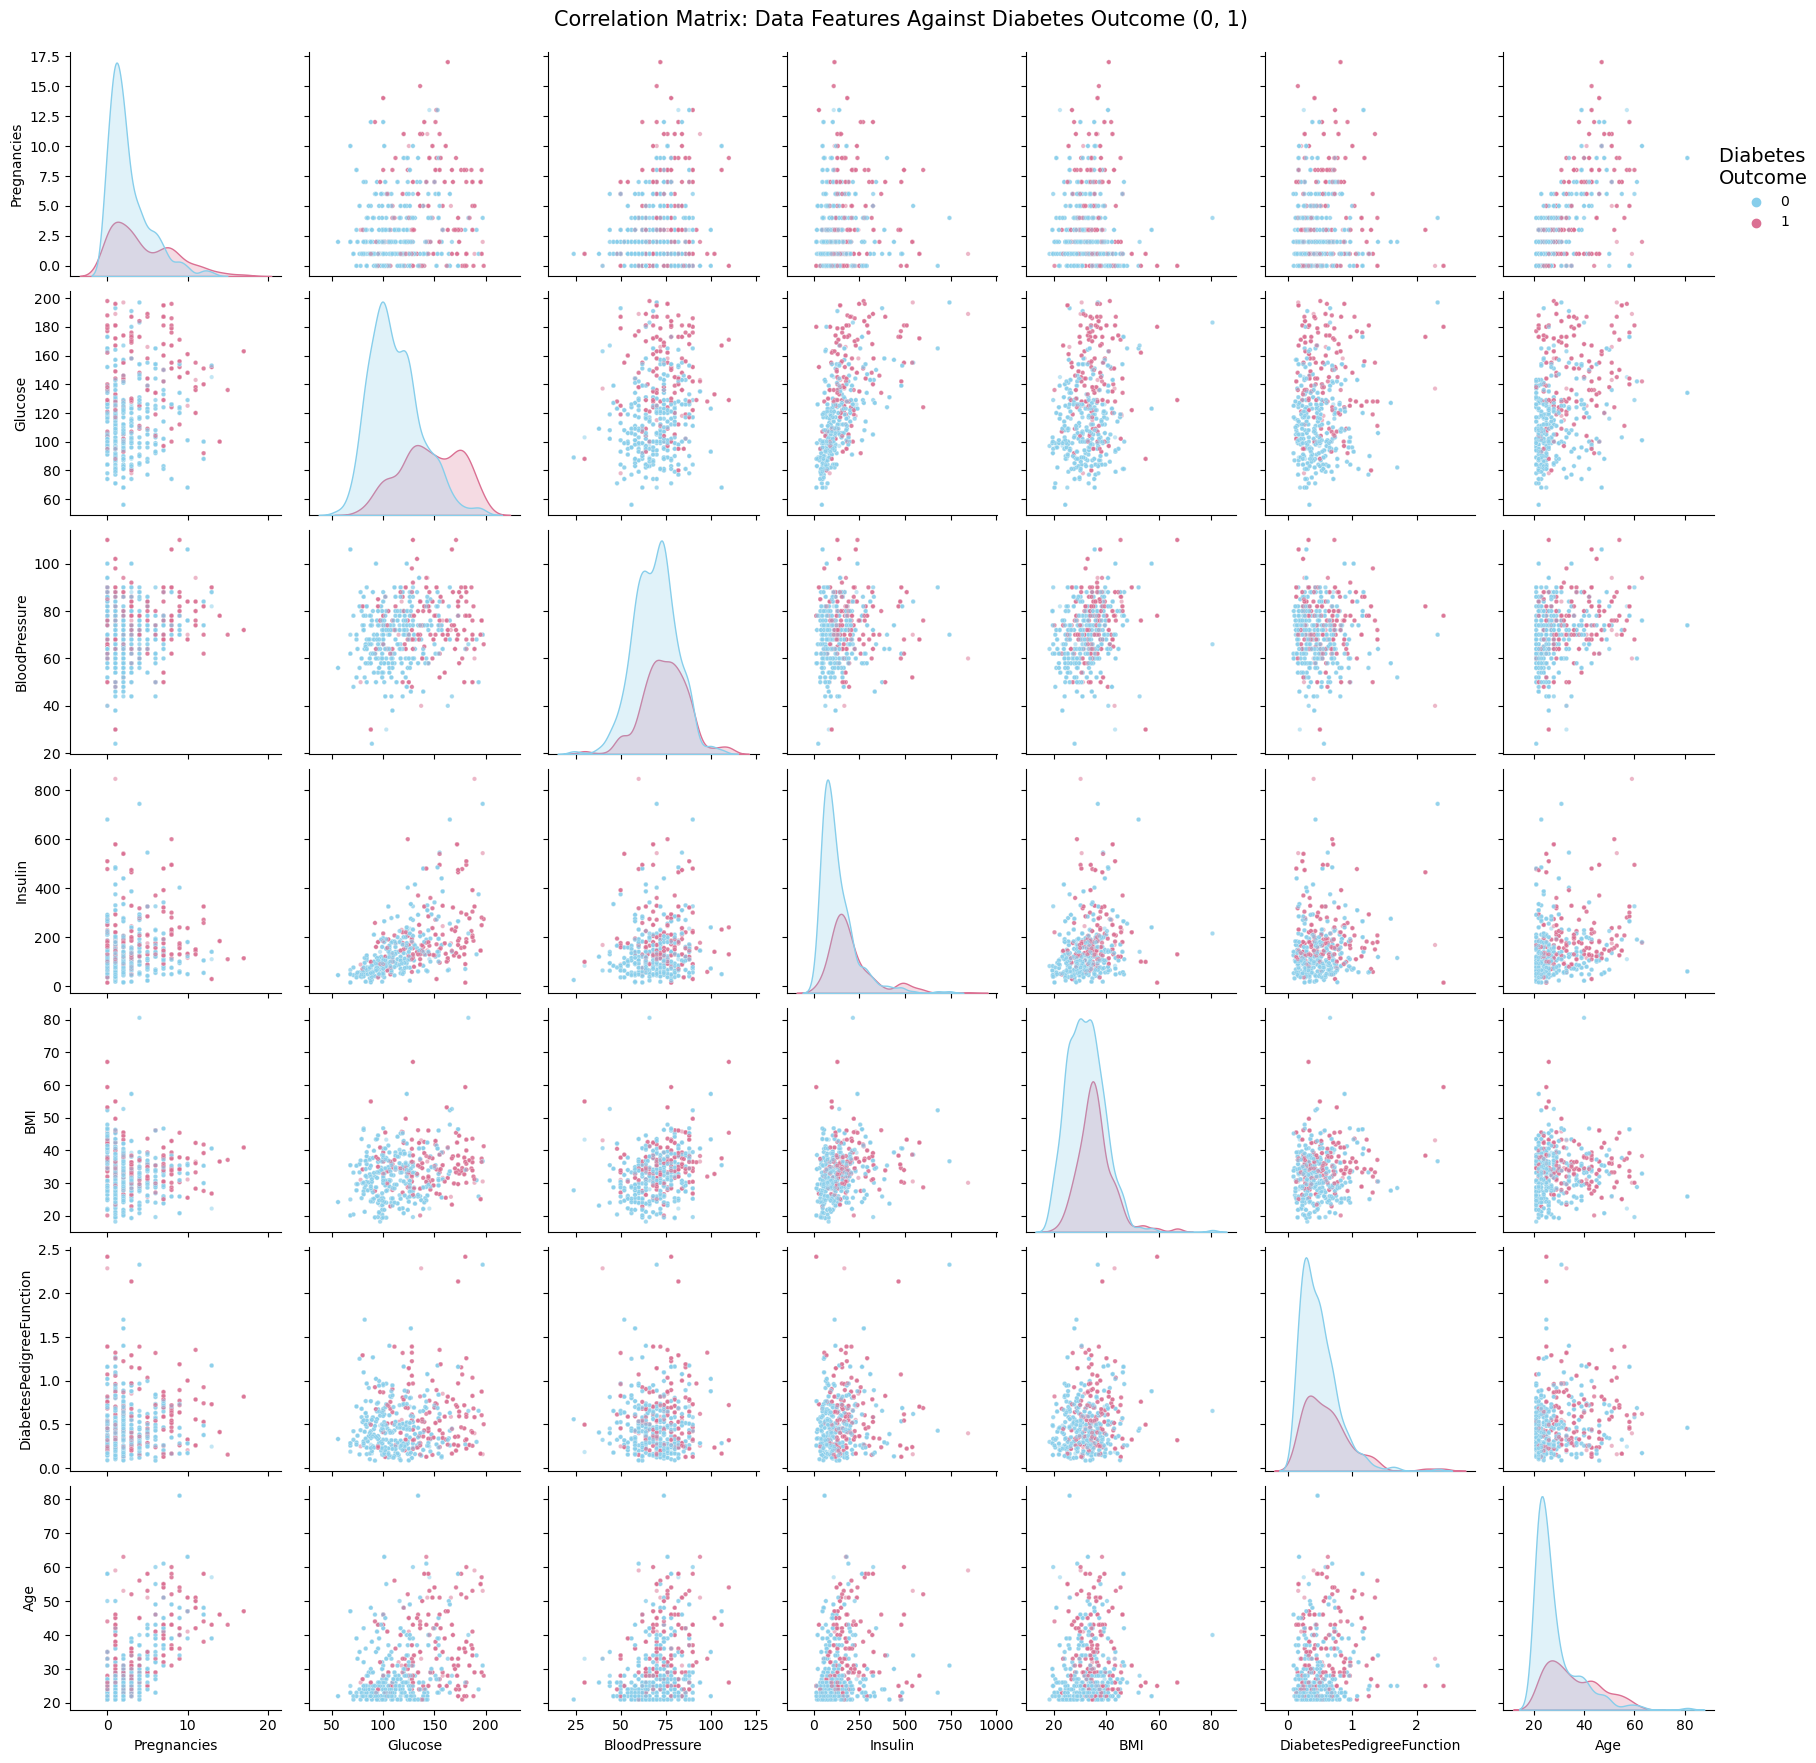

In [16]:
# Create correlation matrix
matrix = sns.pairplot(
    cleaned_data_insulin,
    hue = 'Outcome',
    palette = colors,
    plot_kws = {'alpha' : 0.5,
               's' : 10}
)

# Format matrix
matrix._legend.set_title('Diabetes \nOutcome', prop={'size': 14})
matrix._legend.set_bbox_to_anchor((1, 0.9))
plt.suptitle("Correlation Matrix: Data Features Against Diabetes Outcome (0, 1)", y = 1.01, fontsize = 15);

We see a slightly linear, positive relationship between glucose and insulin, however aisde from this there doesn't seem to be any strong correlations between features indicating we aren't at risk of having colinearities in the data. However, there also doesn't seem to be any strong clustering of the data by outcome across any two features, but there does appear to be a strong relationship between an increase and glucose and diabetes outcome across all variables. 

### Complete Analysis

We now inspect the relationships of features excluding insulin to observe if this impacts any other variables significantly. We ideally would like to maintain a larger sample size so next we decided to remove the features from the dataset missing a significant number of values, these features are: Insulin and Skin Thickness. We then removed individual observations with remaining missing values from Glucose, Blood Pressure and BMI. However given Insulin's predictive potential we will create a model including insulin with a smaller sample size.

In [18]:
# Remove observations with missing values of Glucose, Blood Pressure, and BMI
cleaned_data = data.query('Glucose !=0 & BloodPressure !=0 & BMI !=0').copy()

# Remove features from working dataset with substantial missing values: Insulin, Skin Thickness
cleaned_data.drop(['Insulin','SkinThickness'], axis = 1, inplace = True)
cleaned_data

,Pregnancies,Glucose,BloodPressure,BMI,DiabetesPedigreeFunction,Age,Outcome
Id,,,,,,,
1,6,148,72,33.6,0.627,50,1
2,1,85,66,26.6,0.351,31,0
3,8,183,64,23.3,0.672,32,1
4,1,89,66,28.1,0.167,21,0
5,0,137,40,43.1,2.288,33,1
...,...,...,...,...,...,...,...
2764,2,75,64,29.7,0.370,33,0
2765,8,179,72,32.7,0.719,36,1
2766,6,85,78,31.2,0.382,42,0


We will show the pairwise correlation between all features of the cleaned data set to see if there is any clear change in relationship between outcome and any two features of the dataset with the removal of insulin as a feature

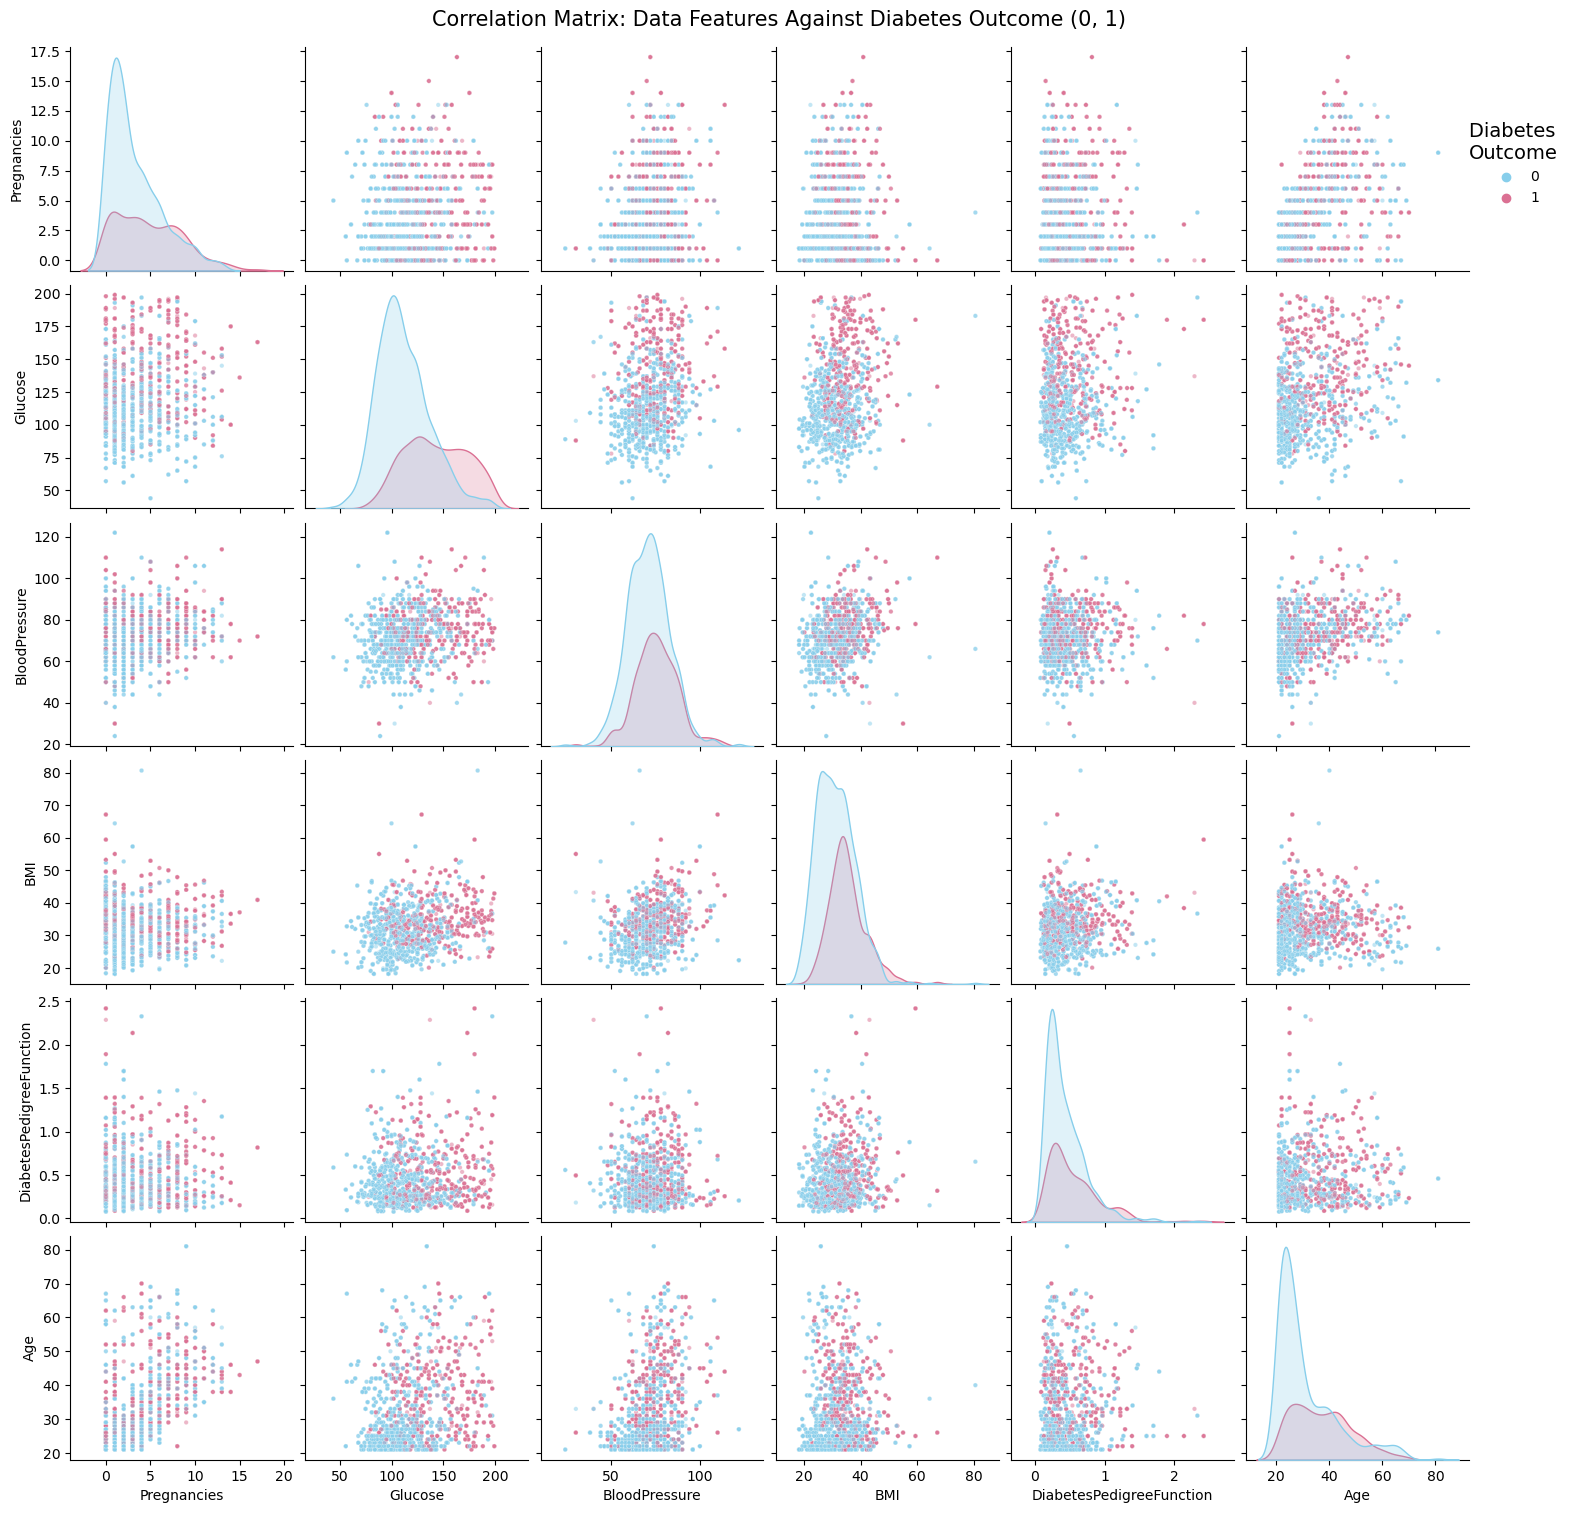

In [20]:
# Create correlation matrix
matrix = sns.pairplot(
    cleaned_data,
    hue = 'Outcome',
    palette = colors,
    plot_kws = {'alpha' : 0.5,
               's' : 10}
)

# Format matrix
matrix._legend.set_title('Diabetes \nOutcome', prop={'size': 14})
matrix._legend.set_bbox_to_anchor((1, 0.9))
plt.suptitle("Correlation Matrix: Data Features Against Diabetes Outcome (0, 1)", y = 1.01, fontsize = 15);

When looking at the scatter plots we see the same trends as in the previous correlation matrix. With this in mind, we proceed using the cleaned data set excluding insulin. We predict that maintaining a larger sample size will more positively impact the ability of our model to determine diabetes diagnosis.

Thus, at the end of our exploratory data analysis, we have cleaned the dataset and can move on to build and evaluate potential models.

## Model Building

Prior to building any models, we will split the dataset into testing and training sets for datasets. This allows us to determine the accuracy of the model against unseen data. 

In [22]:
# Split the data into train and test datasets 
x_train, x_test, y_train, y_test = train_test_split(
    cleaned_data.drop(columns = 'Outcome', axis = 1),
    cleaned_data.Outcome,
    test_size = 0.3, 
    random_state = 3870)
x_train

,Pregnancies,Glucose,BloodPressure,BMI,DiabetesPedigreeFunction,Age
Id,,,,,,
2056,0,105,84,27.9,0.741,62
2514,1,120,80,38.9,1.162,41
1778,6,114,88,27.8,0.247,66
1444,6,195,70,30.9,0.328,31
628,0,132,78,32.4,0.393,21
...,...,...,...,...,...,...
1899,3,123,100,57.3,0.880,22
2342,2,89,90,33.5,0.292,42
1526,0,123,72,36.3,0.258,52


### Logistic Regression 
Next, we use the training set to create and fit a logistic regression classification model. 

In [24]:
# Create and fit a logistic regression model 
log_reg = (
    lm.LogisticRegression(penalty = None,  # No regularization
                          solver = 'lbfgs',
                          max_iter = 1000)
    .fit(X = x_train, y = y_train)         # Fit the model to training data
)
# Displaying the model estimates
log_df = pd.DataFrame({
    'Term': ['Intercept'] + x_train.columns.tolist(),
    'Estimate': np.concatenate((log_reg.intercept_, log_reg.coef_.flatten()), axis = 0).round(3)
})
log_df['Odds Ratio'] = np.exp(log_df['Estimate']).round(3)
log_df

,Term,Estimate,Odds Ratio
0,Intercept,-8.836,0.000
1,Pregnancies,0.127,1.135
2,Glucose,0.035,1.036
3,BloodPressure,-0.001,0.999
4,BMI,0.073,1.076
5,DiabetesPedigreeFunction,0.747,2.111
6,Age,0.016,1.016


The odds ratio will tell us how the odds of a diabetes diagnosis change with an increase in the predictor feature, while all other features remain constant. In this analysis, we can see that there is little to no association between blood pressure and a diabetes diagnosis, as its odds ratio is close to 1. In contrast, the Diabetes Pedigree Function shows a stronger association, with a higher odds ratio indicating increased odds of a diabetes diagnosis as this value rises. The other features examined, such as BMI, Glucose, and Pregnancies, demonstrate slight associations with diabetes diagnosis, reflected by odds ratios slightly above 1.

Now that we know how impactful each feature is on the model, lets see how accurate the logistic regression model is. 

In [26]:
# Create a function to convert predicted probabilities to binary predictors
def threshold_pred(p, t):
    return (p >= t) * 1
    
# Predict probabilities for diabetes and convert them to binary predictions
log_reg_prob = log_reg.predict_proba(X = x_test)[:,1]

# Tune threshold
log_reg_predict = {}
log_reg_accuracy = {}
values = np.arange(0.1,1,0.1)
for value in values:
    v = value.round(2)
    log_reg_predict[f'{v}'] = threshold_pred(log_reg_prob, v)
    log_reg_accuracy[f'{v}'] = np.mean(log_reg_predict[str(v)] == np.array(y_test)).round(4)

# Print the accuracy of the logistic regression model 
for key in log_reg_accuracy:
    print(f'The accuracy of model with threshold {key} is: {log_reg_accuracy[key]}') 
    
print(f'\nThe accuracy of predicting every patient as non-diabetic: {1-np.mean(y_test).round(4)}') 

# Print the threshold that produces the maximum accuracy
max_key = max(log_reg_accuracy, key=log_reg_accuracy.get)
print(f'The threshold value which produces the model with the maximum accuracy is {max_key} with an accuracy of {log_reg_accuracy[max_key]}')

The accuracy of model with threshold 0.1 is: 0.5421
The accuracy of model with threshold 0.2 is: 0.6913
The accuracy of model with threshold 0.3 is: 0.736
The accuracy of model with threshold 0.4 is: 0.7666
The accuracy of model with threshold 0.5 is: 0.773
The accuracy of model with threshold 0.6 is: 0.7666
The accuracy of model with threshold 0.7 is: 0.7436
The accuracy of model with threshold 0.8 is: 0.7117
The accuracy of model with threshold 0.9 is: 0.6684

The accuracy of predicting every patient as non-diabetic: 0.6582
The threshold value which produces the model with the maximum accuracy is 0.5 with an accuracy of 0.773


From our calculations, we can see our logistc regression model has decent accuracy, and will predict a patient's diabetes diagnosis 77.3% of the time. This is better than just predicting every patient was not diabetic, which is correct 65.82% of the time.

To better understand the accuracy of our model we can create a confusion matrix to understand how often the model is correct, and how often it predicts false positives and false negatives.

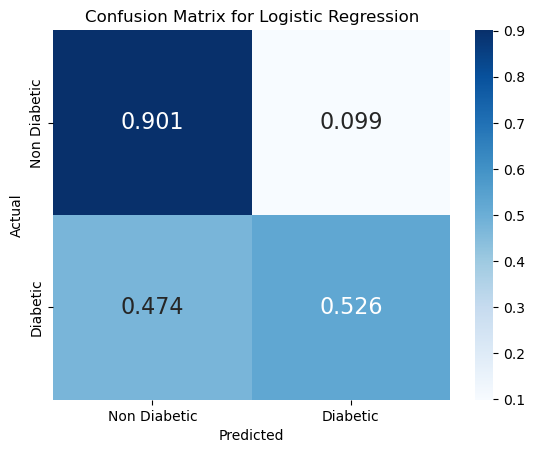

In [28]:
# Create a confusion matrix with the percent accurately predicted 
logistic_regression_confusion_matrix = confusion_matrix(
    y_true = y_test,
    y_pred = log_reg_predict[max_key], 
    normalize = 'true'
)

# Display the confusion matrix
sns.heatmap(logistic_regression_confusion_matrix,
           annot = True,
           fmt = '.3f',
           cmap = 'Blues',
           annot_kws = {'size': 16},
           xticklabels = ['Non Diabetic','Diabetic'],
           yticklabels = ['Non Diabetic','Diabetic'])

plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix for Logistic Regression");

From the confusion matrix we can see that the model correctly predicted non diabetic patients 90.1% of the time. However, it only correctly predicted patients with diabetes 52.6% of the time. This means our model is missing about half of our diabetic patients, which poses significant issues when considering the impacts of missing a diagnosis of diabetes in a patient and prolonging the time until treatment. Before moving on to try and increase our model accuracy using alternative methods, we will try and fit the model with the smaller dataset including insulin.

### Logistic Regression - Insulin

First, we create a new training and testing set using the dataset including insulin.

In [30]:
# Split the data into train and test datasets 
x_train_insulin, x_test_insulin, y_train_insulin, y_test_insulin = train_test_split(
    cleaned_data_insulin.drop(columns = 'Outcome', axis = 1),
    cleaned_data_insulin.Outcome,
    test_size = 0.3, 
    random_state = 3870)
x_train_insulin

,Pregnancies,Glucose,BloodPressure,Insulin,BMI,DiabetesPedigreeFunction,Age
Id,,,,,,,
245,2,146,76,194,38.2,0.329,29
369,3,81,86,66,27.5,0.306,22
723,1,149,68,127,29.3,0.349,42
1462,7,129,68,125,38.5,0.439,43
1765,3,129,92,155,36.4,0.968,32
...,...,...,...,...,...,...,...
826,0,100,88,110,46.8,0.962,31
2688,6,93,50,64,28.7,0.356,23
324,13,152,90,29,26.8,0.731,43


As in our previous analysis, we next use the training set to create and fit a logistic regression classification model.

In [32]:
# Create and fit a logistic regression model 
log_reg_insulin = (
    lm.LogisticRegression(penalty = None,  # No regularization
                          solver = 'lbfgs',
                          max_iter = 1000)
    .fit(X = x_train_insulin, y = y_train_insulin)         # Fit the model to training data
)
# Displaying the model estimates
log_df_insulin = pd.DataFrame({
    'Term': ['Intercept'] + x_train_insulin.columns.tolist(),
    'Estimate': np.concatenate((log_reg_insulin.intercept_, log_reg_insulin.coef_.flatten()), axis = 0).round(3)
})
log_df_insulin['Odds Ratio'] = np.exp(log_df_insulin['Estimate']).round(3)
log_df_insulin

,Term,Estimate,Odds Ratio
0,Intercept,-9.588,0.000
1,Pregnancies,0.116,1.123
2,Glucose,0.038,1.039
3,BloodPressure,0.013,1.013
4,Insulin,-0.001,0.999
5,BMI,0.044,1.045
6,DiabetesPedigreeFunction,1.203,3.330
7,Age,0.021,1.021


In [33]:
# Predict probabilities for diabetes and convert them to binary predictions
log_reg_prob_insulin = log_reg_insulin.predict_proba(X = x_test_insulin)[:,1]

# Tune threshold
log_reg_predict_insulin = {}
log_reg_accuracy_insulin = {}
values = np.arange(0.1,1,0.1)
for value in values:
    v = value.round(2)
    log_reg_predict_insulin[f'{v}'] = threshold_pred(log_reg_prob_insulin, v)
    log_reg_accuracy_insulin[f'{v}'] = np.mean(log_reg_predict_insulin[str(v)] == np.array(y_test_insulin)).round(4)

# Print the accuracy of the logistic regression model 
for key in log_reg_accuracy_insulin:
    print(f'The accuracy of model with threshold {key} is: {log_reg_accuracy_insulin[key]}') 
    
print(f'\nThe accuracy of predicting every patient as non-diabetic: {1-np.mean(y_test_insulin).round(4)}') 

# Print the threshold that produces the maximum accuracy
max_key_insulin = max(log_reg_accuracy_insulin, key=log_reg_accuracy_insulin.get)
print(f'The threshold value which produces the model with the maximum accuracy is {max_key_insulin} with an accuracy of {log_reg_accuracy_insulin[max_key_insulin]}')

The accuracy of model with threshold 0.1 is: 0.5105
The accuracy of model with threshold 0.2 is: 0.7203
The accuracy of model with threshold 0.3 is: 0.7832
The accuracy of model with threshold 0.4 is: 0.8112
The accuracy of model with threshold 0.5 is: 0.8065
The accuracy of model with threshold 0.6 is: 0.7879
The accuracy of model with threshold 0.7 is: 0.7972
The accuracy of model with threshold 0.8 is: 0.7646
The accuracy of model with threshold 0.9 is: 0.7296

The accuracy of predicting every patient as non-diabetic: 0.7133
The threshold value which produces the model with the maximum accuracy is 0.4 with an accuracy of 0.8112


From our calculations, we can see our logistc regression model where insulin is included as a feature has increased accuracy as compared to our model where insulin was excluded as a feature. This second model predicts a patient's diabetes diagnosis 81.12% of the time. This is better than just predicting every patient was not diabetic, which is correct 71.33% of the time. 

To better understand the accuracy of our model we can create a confusion matrix to understand how often the model is correct, and how often it predicts false positives and false negatives.

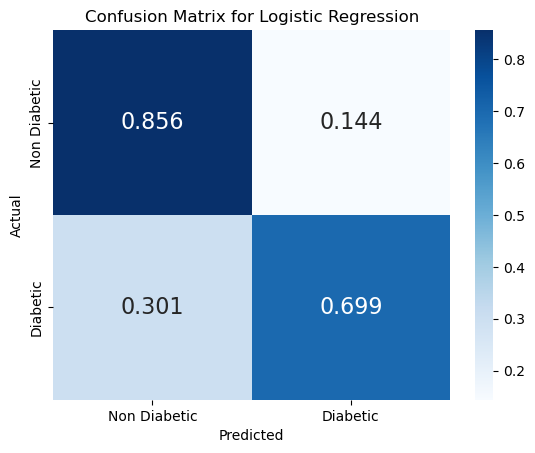

In [35]:
# Create a confusion matrix with the percent accurately predicted 
logistic_regression_confusion_matrix_insulin = confusion_matrix(
    y_true = y_test_insulin,
    y_pred = log_reg_predict_insulin[max_key_insulin], 
    normalize = 'true'
)

# Display the confusion matrix
sns.heatmap(logistic_regression_confusion_matrix_insulin,
           annot = True,
           fmt = '.3f',
           cmap = 'Blues',
           annot_kws = {'size': 16},
           xticklabels = ['Non Diabetic','Diabetic'],
           yticklabels = ['Non Diabetic','Diabetic'])

plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix for Logistic Regression");

Here we further prove that including insulin in the dataset improves the model as compared to excluding insulin. We see that our model correctly predicts an individual as non-diabetic 85.6% of the time and correctly predicts an individual as diabetic 69.9% of the time (as compared to 90.1% and 52.6%. While the previous model has a higher prediction rate for non-diabetic patients, our second model has only a slight decrease in this category and a significat increase in positive diabetes prediction. In a healthcare context there is a more significant cost to a false negative diagnosis than a false positive. 

Although the overall accuracy is improved by including the insulin feature, we can see from the odds ratio that it is not contributing very much to the preduction, as a 1 unit increase in 2-hour serum insulin results in only a 1% decrease in the odds of having diabetes. The increase in accuracy could be simply due to the decrease in the number of observations. Due to its limited predictive functionality we will continue without using the insulin feature.


There is still significant room for improvement with this model and as such, we will move towards ensemble methods: Random Forest and XGBoost.

### Random Forest

First we will perform a grid search to identify the best hyperparameter values before proceeding to creating the Random Forest. 

In [37]:
# Form the grid of values to choose hyperparameter values from 
hps_grid = {
    'n_estimators': [10, 50, 100, 200, 300, 400, 500],
    'max_features': np.arange(1,7, 1).tolist(),
    'max_depth': [1, 2, 10, 20, 50, None]
}


Then we will perform cross validation to select the best hyperparameters.

In [39]:
# 5-fold cv partition
cv5 = KFold(n_splits = 5, shuffle = True, random_state = 3870)

# Create instance of GridSearchCV engine 
hp_grid_search = GridSearchCV(
    ensemble.RandomForestClassifier(random_state = 3870),
    hps_grid,
    cv = cv5,
    scoring = 'accuracy',
    n_jobs = -1
)

In [40]:
# Fit the training data to the GridSearcCV engine 
hp_grid_search.fit(X = x_train, y = y_train)

GridSearchCV(cv=KFold(n_splits=5, random_state=3870, shuffle=True),
             estimator=RandomForestClassifier(random_state=3870), n_jobs=-1,
             param_grid={'max_depth': [1, 2, 10, 20, 50, None],
                         'max_features': [1, 2, 3, 4, 5, 6],
                         'n_estimators': [10, 50, 100, 200, 300, 400, 500]},
             scoring='accuracy')

In [41]:
# Print the best hyperparameters
print(f"The best choice for the number of trees is {hp_grid_search.best_params_['n_estimators']}")
print(f"The best choice for the number of features is {hp_grid_search.best_params_['max_features']}")
print(f"The best choice for max depth is {hp_grid_search.best_params_['max_depth']}")
print(f"which has an accuracy of: {hp_grid_search.best_score_: .4f}")

The best choice for the number of trees is 100
The best choice for the number of features is 1
The best choice for max depth is 20
which has an accuracy of:  0.9710


In [42]:
# Display the overall best model
best_model = hp_grid_search.best_estimator_
best_model

RandomForestClassifier(max_depth=20, max_features=1, random_state=3870)

After the grid search, we have found the best Random Forest model includes one hundred trees, each with one feature, and a maximum depth of twenty. This model generates an accuracy of 0.9790 on average across five cross-validation folds. This is considered a good model, with significant improvement in predicting diabetes diagnoses than that generated by the logistic regression.

Now that we have determined the best hyper parameters for our model and fit it to our data to create the best model, we will evaluate the accuracy of the model using our testing set. 

In [44]:
# Accuracy of best model with train and test sets
rf_training_accuracy = best_model.score(x_train, y_train)
rf_testing_accuracy = best_model.score(x_test, y_test)
print('Training Accuracy: ',round(rf_training_accuracy, 3), ' Testing Accuracy: ',round(rf_testing_accuracy, 3))

Training Accuracy:  1.0  Testing Accuracy:  0.985


The model perfectly classified all cases in the training set, this might suggest overfitting however the model has a 98.5% accuracy on the testing set, indicating it predicts diabetes very well. Next we will examine the confusion matrix for this model. 

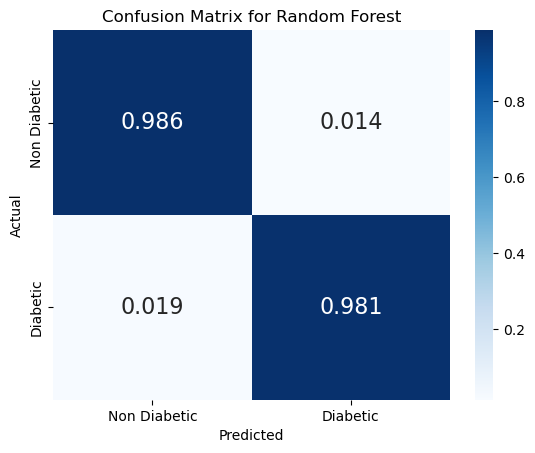

In [46]:
# Determine the predicted y values from the best model
y_pred = best_model.predict(X=x_test)

# Create a confusion matrix with the percent accurately predicted 
random_forest_confusion_matrix = confusion_matrix(
    y_true = y_test,
    y_pred = y_pred, 
    normalize = 'true'
)

# Display the confusion matrix
sns.heatmap(random_forest_confusion_matrix,
           annot = True,
           fmt = '.3f',
           cmap = 'Blues',
           annot_kws = {'size': 16},
           xticklabels = ['Non Diabetic','Diabetic'],
           yticklabels = ['Non Diabetic','Diabetic'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix for Random Forest");

The Random Forests confusion matrix shows much improvement from the logistic regression model. It correctly predicted non-diabetics 98.6% of the time, and diabetics 98.1% of the time. This shows significant improvement in the model and promise that diabetes diagnosis can be predicted by useful known health factors. The model’s strong accuracy in both categories suggests it could be a valuable tool in early detection and prevention strategies for at-risk populations.


### XGBoost
The second non-parametric model we will use to predict diabetes in patients is XGBoost. First we must determine the best combination of hyper parameters using a grid search in the same way we did earlier but with XGBClassifier this time. 

In [49]:
# Form the grid of values to choose hyper parameter values from 

xgb_hp_dict = {
    'learning_rate':    [0.01, 0.05, 0.1, 0.2, 0.3], # Each new prediction's contribution to y_hat
    'n_estimators':     [100, 250, 500, 750, 1000],  # Number of trees to make
    'max_depth':        [1, 3, 5, 7],                # Maximum number of splits: 1, 8, 32, 128 leaf nodes   
    'colsample_bytree': [0.4, 0.6, 0.8, 1],          # Number of features to use per tree (40, 60, 80, & 100%)
    'lambda':           [0, 0.5, 1, 2, 5]            # Regularization parameters to try
}

# 5 fold cross-val
cv5 = KFold(n_splits = 5, shuffle = True, random_state = 3870)

# Defining the model:
xgb_class = XGBClassifier(random_state = 3870, early_stopping_rounds = 50)

# Defining the grid search
grid_search = GridSearchCV(
    estimator = xgb_class,
    param_grid = xgb_hp_dict,
    n_jobs = -1,
    cv = cv5    
)

In [50]:
# Conducting the grid search
gs_results = (
    grid_search
    .fit(
        x_train, y_train,
        eval_set = [(x_test, y_test)],
        verbose = False
    )
)

print(f"The best choice for the number of trees (n_estimators) is {grid_search.best_params_['n_estimators']}")
print(f"The best choice for the fraction of features (colsample_bytree) is {grid_search.best_params_['colsample_bytree']}")
print(f"The best choice for max depth (max_depth) is {grid_search.best_params_['max_depth']}")
print(f"The best choice for learning rate (learning_rate) is {grid_search.best_params_['learning_rate']}")
print(f"The best choice for L2 regularization (lambda) is {grid_search.best_params_['lambda']}")
print(f"The best cross-validated accuracy is {grid_search.best_score_: .4f}")

The best choice for the number of trees (n_estimators) is 500
The best choice for the fraction of features (colsample_bytree) is 0.6
The best choice for max depth (max_depth) is 5
The best choice for learning rate (learning_rate) is 0.3
The best choice for L2 regularization (lambda) is 2
The best cross-validated accuracy is  0.9710


Next, we will define the best model and fit it with the testing and training data. 

In [52]:
#define the best model and fit to data
xgb_best_model = (
    XGBClassifier(
        **best_hps,  # Assigns the dictionary values to the parameter keys
        random_state = 3870,
        early_stopping_rounds = 20
    )
    .fit(
        x_train, y_train,
        eval_set = [(x_test, y_test)],
        verbose = False
    )
)

# Calculating the accuracy of the model
accuracy_xgb_tuned = xgb_best_model.score(x_test, y_test)
print('Train Accuracy: ',xgb_best_model.score(x_train, y_train), ' Test Accuracy: ', round(accuracy_xgb_tuned, 3))

NameError: name 'best_hps' is not defined

Again, as expected, the accuracy of the XGBoost model on the training data is 1.0, and on the training data is 0.986. This indicates the accuracy of the XGBoost model is very good, and is marginally higher than the Random Forest. 

To further determine the quality of the model we will make another confusion matrix. 

In [ ]:
# Determine the predicted y values from the best model
xgb_y_pred = xgb_best_model.predict(X = x_test)

# Create a normalized confusion matrix of true/ false positives and negatives
XGB_confusion_matrix = confusion_matrix(
    y_true = y_test,
    y_pred = xgb_y_pred, 
    normalize = 'true'
)
# Display the confusion matrix
sns.heatmap(XGB_confusion_matrix,
           annot = True,
           fmt = '.3f',
           cmap = 'Blues',
           annot_kws = {'size': 16},
           xticklabels = ['Non Diabetic','Diabetic'],
           yticklabels = ['Non Diabetic','Diabetic'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix for XGboost");

The XGBoost model has the same accuracy, and predictions as the Random Forest model, indicating that with our data, a more complex model does not inherently make a better model for our data. 

In [ ]:
# Check if both ensemble methods provided the same predictions
predictions = y_pred == xgb_y_pred

# Check for False values
num_false = np.sum(predictions == False)
print(f'There are {num_false} predictions that do not match between Random Forest and XGboost')

## Summary and Conclusions

Our project aims to explore if we can predict diabetes diagnoses with known health data, via multiple machine learnign models. We explored parametric and non parametric methods: logistic regression, Random Forests, and XGBoost. Useful factors from our data includes glucose levels, BMI, age, diabetes pedigree function, insulin levels,  and number of pregnancies. 

The first modelling method used was logistic regression, a non-parametric method for binary, categorical outcome variables. This model showed decent accuracy, predicting correctly 77.3% of the time. However, upon further analysis, this model only correctly predicted those without diabetes, and had a high false negative rate of 47.4%. This model would miss almost half of diabetic patients, which could have severe consequences in a medical setting when early intervention, treatment, and diagnosis can impact a patient's wellbeing and quality of life. To see if we could improve on this method, we included the 2-hour serum insulin feature in our dataset, causing us to remove around half of the obersevations that had missing values. However, including this feature led to an increase in accuracy to 81.12% which is around 10% higher than if we were to predict each patient as a non-diabetic. Yet, when looking at how much the insulin feature contributed to the predictions made by the model it had only minimal predictive power leading us to dropping that feature for the rest of our analysis. 

The second model used was Random Forest, which improved upon the accuracy of the logistic regression model to 98.5% on the testing set. Upon further analysis of the confusion matrix, the model had significant improvement with the false negative rates remaining at 1.9%. 

The third model used was XGBoost, which is a more complex model, however it did not yield a higher accuracy, remaining at 98.5%. The confusion matrix shows a similar trend, with the false positive rate being equivalent to the 1.6% of the Random Forests model. XGboost has a slighly higher true negative rate than teh Random Forest model at 98.8%. When checked there is only one prediction that differs between the two ensemble methods indicating both found similar predictive patterns in the data.

Overall, these models demonstrated the potential of using known health features to accurately predict diabetes in patients, showing promise as a tool for early detection and prevention strategies to improve the quality of life for diabetic patients. 

## Limitations and Recommendations

The first major limitation is the amount of missing values in the 2-hour serum Insulin column in our data set. This required us to eliminate around half of our observations greatly decreasing our sample size, because of this we ended up dropping that feature entirely. In addition, the pregnancy column does not discriminate between those who cannot get pregnant with those who can, resulting in an over reporting of zero pregnancies, therefore potentially skewing the relationship between diabetes and pregnancies. Lastly, future research should also focus on improving data quality by minimizing missing values for critical features. 

Second, this data set does not include socioeconomic factors, which we know can be highly associated with diabetes in patients. Factors like sex, race, income, and housing status could all impact the predictive ability of a model for diabetes. 

Third, the data set has a high sample size which creates large test statistics and small p-values, which can potentially inflate the statistical significance of the difference of groups in the two sample t-tests. 

In addition, using machine learning as a predictive tool in diagnostic techniques is still heavily debated in the medical field. Our project highlights the limitations of model building, where the potential for missed diagnoses is high. 

Future recommendations include increasing the number of socioeconomic factors recorded for each patient, and explore other clinical study types to best explore the diagnosis. A cohort study would provide more perspective to the features that impact diabetes by providing a timeframe of when a patient was diagnosed with diabetes, and may illude to what features changed leading to that diagnosis

